# RL Agent & Brain Encoding Tutorial

## Prerequisites

**This notebook requires variables from the main tutorial:**

You must run **Section 3 (GLM Analysis)** from `MAIN2025_educational.ipynb` first, which provides:
- `runs` - List of run IDs (e.g., ['run-1', 'run-2', ...])
- `all_events` - Event DataFrames for each run
- `common_mask` - Brain mask from multi-run GLM
- `sourcedata_path` - Path to data

**Or run this cell to load them:**

In [1]:
# Setup - imports and configuration

import sys
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Add src to path
src_dir = Path('..') / 'src'
sys.path.insert(0, str(src_dir))

# Import utilities
from utils import (
    get_sourcedata_path,
    load_events,
    get_session_runs,
    load_bold
)

# Import RL utilities
from rl_utils import (
    create_simple_proxy_features,
    convolve_with_hrf,
    apply_pca
)

# Import RL visualizations
from rl_viz_utils import (
    plot_pca_variance_per_layer,
    plot_layer_activations_sample
)

# Import encoding utilities
from encoding_utils import (
    load_and_prepare_bold,
    fit_encoding_model_per_layer,
    compare_layer_performance
)

# Import encoding visualizations
from encoding_viz_utils import (
    plot_layer_comparison_bars,
    plot_r2_brainmap
)

# Plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 11

# Get sourcedata path
sourcedata_path = get_sourcedata_path()

print("✓ Setup complete!")

✓ Setup complete!


# Section 4: RL Agent

## Learning Representations from Gameplay

## Why RL for fMRI?

### Limitations of Traditional GLM

**GLM approach:**
- Hand-crafted regressors (LEFT, RIGHT, Powerup, etc.)
- Hypothesis-driven
- Interpretable but limited

**Problems:**
- Can't capture complex strategies
- Misses latent variables (intentions, predictions, value)
- Requires knowing what to look for

## RL Agent Approach

**Key idea:** Train agent to play → Extract learned representations → Predict brain activity

**Advantages:**
1. **Data-driven:** No assumptions about relevant features
2. **Hierarchical:** Multiple levels of abstraction (pixels → strategy)
3. **Latent variables:** Captures value, predictions, uncertainty
4. **Hypothesis generation:** Discover what brain encodes

**Hypothesis:** Brain uses similar representations as RL agent for gameplay

## PPO Agent Architecture

### Proximal Policy Optimization (PPO)

**Input:** 4 stacked frames (84×84 grayscale) → Temporal context

**Convolutional layers (feature hierarchy):**
```
conv1: 4 → 32 channels (42×42)   # Edges, colors
conv2: 32 → 32 channels (21×21)  # Textures, patterns  
conv3: 32 → 32 channels (11×11)  # Objects, enemies
conv4: 32 → 32 channels (6×6)    # Spatial relations
linear: 1152 → 512 features      # Strategy, value
```

## PPO Architecture (continued)

**Output heads:**
- **Actor:** 512 → 12 actions (LEFT, RIGHT, A, B, combinations)
- **Critic:** 512 → 1 value (expected future reward)

**Analogy to visual cortex:**
- conv1/conv2 ≈ V1/V2 (primary visual cortex)
- conv3/conv4 ≈ V4/IT (object recognition)
- linear ≈ PFC (executive function, planning)

**Total parameters:** ~150k (compact but powerful)

In [2]:
# Check for pretrained agent weights

from pathlib import Path

MODEL_DIR = Path('../models')
MODEL_PATH = MODEL_DIR / 'mario_ppo_agent.pth'

if MODEL_PATH.exists():
    print(f"✓ Found pretrained weights: {MODEL_PATH}")
    print(f"  File size: {MODEL_PATH.stat().st_size / 1e6:.1f} MB")
    HAS_WEIGHTS = True
else:
    print(f"✗ No pretrained weights found at: {MODEL_PATH}")
    print(f"\nTo train agent, run:")
    print(f"  python ../train_mario_agent.py --steps 5000000")
    print(f"\nOr for quick demo (10k steps, ~2 min):")
    print(f"  python ../train_mario_agent.py --steps 10000")
    print(f"\n→ For now, using behavioral proxy features")
    HAS_WEIGHTS = False

✓ Found pretrained weights: ../models/mario_ppo_agent.pth
  File size: 7.5 MB


## Minimal Training Example

Before we watch the agent play, let's see a minimal example of how the agent is trained.

**Training procedure:**
1. Agent plays the game and collects experience (observations, actions, rewards)
2. Compute advantages using Generalized Advantage Estimation (GAE)
3. Update policy using PPO loss (clipped objective)
4. Repeat for millions of steps

**For the full training script, see:** `../train_mario_agent.py`

In [3]:
# Minimal PPO training example (simplified from train_mario_agent.py)

print("Training Loop Overview:\n")
print("=" * 60)
print("1. Collect rollout (128 steps):")
print("   - Agent plays game")
print("   - Store: states, actions, rewards, values")
print()
print("2. Compute advantages (GAE):")
print("   - Estimate how much better each action was")
print("   - Uses TD(λ) with γ=0.9, λ=0.95")
print()
print("3. Update policy (PPO):")
print("   - Policy loss: clipped surrogate objective")
print("   - Value loss: MSE between predicted and actual returns")
print("   - Entropy bonus: encourages exploration")
print()
print("4. Repeat for ~5M steps (~2 hours on GPU)")
print("=" * 60)
print("\n✓ To train your own agent:")
print("  python ../train_mario_agent.py --steps 5000000 --gpu")

Training Loop Overview:

1. Collect rollout (128 steps):
   - Agent plays game
   - Store: states, actions, rewards, values

2. Compute advantages (GAE):
   - Estimate how much better each action was
   - Uses TD(λ) with γ=0.9, λ=0.95

3. Update policy (PPO):
   - Policy loss: clipped surrogate objective
   - Value loss: MSE between predicted and actual returns
   - Entropy bonus: encourages exploration

4. Repeat for ~5M steps (~2 hours on GPU)

✓ To train your own agent:
  python ../train_mario_agent.py --steps 5000000 --gpu


Training Progress:

Configuration:
  n_steps: 100000
  rollout_length: 128
  n_epochs: 4
  batch_size: 32
  eval_interval: 10000
  device: cpu
  levels: Level1-1, Level1-2, Level4-1, Level4-2, Level5-1, Level5-2

Final Statistics:
  total_episodes: 17
  final_mean_reward: 1256.5294117647059


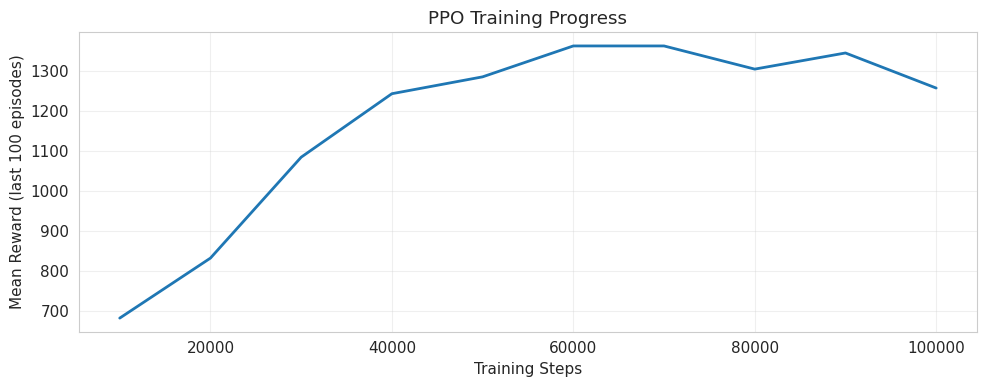


✓ Agent trained for 100,000 steps


In [4]:
# Load training log if available

import json
from pathlib import Path

LOG_PATH = Path('../models/training_log.json')

if LOG_PATH.exists():
    with open(LOG_PATH, 'r') as f:
        training_log = json.load(f)
    
    print("Training Progress:\n")
    print(f"Configuration:")
    for key, val in training_log['config'].items():
        if key != 'levels':
            print(f"  {key}: {val}")
    print(f"  levels: {', '.join(training_log['config']['levels'])}")
    
    print(f"\nFinal Statistics:")
    for key, val in training_log['final_stats'].items():
        if key != 'level_episodes':
            print(f"  {key}: {val}")
    
    # Plot training curve
    if len(training_log['progress']) > 0:
        import matplotlib.pyplot as plt
        
        progress = training_log['progress']
        steps = [p['step'] for p in progress]
        mean_rewards = [p['mean_reward'] for p in progress]
        
        fig, ax = plt.subplots(figsize=(10, 4))
        ax.plot(steps, mean_rewards, linewidth=2)
        ax.set_xlabel('Training Steps')
        ax.set_ylabel('Mean Reward (last 100 episodes)')
        ax.set_title('PPO Training Progress')
        ax.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
        
        print(f"\n✓ Agent trained for {steps[-1]:,} steps")
else:
    print("⚠ No training log found. Agent may have been trained elsewhere.")
    print(f"  Expected: {LOG_PATH}")

## Agent Gameplay Demonstration

Let's watch the trained agent play a level!

**What you'll see:**
- Agent playing in real-time
- Actions being selected by the CNN
- Level progression

**Select a level below to watch the agent play.**

In [5]:
# Agent gameplay demonstration

if HAS_WEIGHTS:
    import importlib
    import rl_utils
    importlib.reload(rl_utils)
    from rl_utils import load_pretrained_model, play_agent_episode
    
    # Select level to play
    available_levels = ['Level1-1', 'Level1-2', 'Level4-1', 'Level4-2', 'Level5-1', 'Level5-2']
    
    print("Available levels:")
    for idx, level in enumerate(available_levels):
        print(f"  {idx}: {level}")
    
    # Select level (change this number to play different levels)
    level_idx = 0  # Play Level1-1 by default
    selected_level = available_levels[level_idx]
    
    print(f"\nPlaying: {selected_level}\n")
    
    # Load trained model
    model = load_pretrained_model(MODEL_PATH, device='cpu')
    print("✓ Model loaded\n")
    
    # Play episode
    print("▶ Playing... (close window to stop)\n")
    results = play_agent_episode(model, selected_level, sourcedata_path, max_steps=5000)
    
    # Show results
    print(f"\n✓ Episode complete!")
    print(f"  Steps: {results['steps']}")
    print(f"  Total reward: {results['reward']:.1f}")
    print(f"  Completed: {'Yes' if results['completed'] else 'No'}")
    
else:
    print("⚠ No trained weights available.")
    print("  Train agent first: python ../train_mario_agent.py --steps 5000000")

Available levels:
  0: Level1-1
  1: Level1-2
  2: Level4-1
  3: Level4-2
  4: Level5-1
  5: Level5-2

Playing: Level1-1

✓ Model loaded

▶ Playing... (close window to stop)


Window closed by user.

✓ Episode complete!
  Steps: 1341
  Total reward: 408.0
  Completed: No


## Exploring Agent Activations with PCA

Now that we've seen the agent play, let's extract and analyze its internal representations.

**Goal:** Understand what the agent's neurons encode during gameplay

**Approach:**
1. Extract activations from each CNN layer during gameplay
2. Apply PCA to reduce dimensionality
3. Visualize the learned representations

In [6]:
# Extract CNN activations from agent gameplay

if HAS_WEIGHTS:
    from rl_utils import extract_layer_activations, load_pretrained_model
    
    print("Extracting activations from agent playing Level1-1...\n")
    
    # Load model
    model = load_pretrained_model(MODEL_PATH, device='cpu')
    
    # Play and extract activations
    layer_activations = extract_layer_activations(
        model, 
        level='Level1-1',
        sourcedata_path=sourcedata_path,
        max_steps=1000
    )
    
    print("Layer activations extracted:\n")
    for layer_name, acts in layer_activations.items():
        print(f"  {layer_name:8s}: {acts.shape}")
    
    print("\n✓ Activations ready for PCA")
else:
    print("⚠ No trained weights available - skipping activation extraction")

ImportError: cannot import name 'extract_layer_activations' from 'rl_utils' (/home/hyruuk/GitHub/neuromod/mario_analysis/mario.tutorials/notebooks/../src/rl_utils.py)

In [ ]:
# Apply PCA to each layer

if HAS_WEIGHTS:
    from rl_utils import apply_pca
    
    N_COMPONENTS = 50
    
    print("Applying PCA to reduce dimensionality...\n")
    
    pca_results = {}
    reduced_activations = {}
    
    for layer_name, acts in layer_activations.items():
        reduced, pca_model, variance_explained = apply_pca(
            acts, n_components=N_COMPONENTS, variance_threshold=0.9
        )
        
        pca_results[layer_name] = {
            'pca': pca_model,
            'variance_explained': variance_explained
        }
        reduced_activations[layer_name] = reduced
        
        total_var = np.sum(variance_explained)
        print(f"  {layer_name:8s}: {acts.shape[1]:,} → {reduced.shape[1]} "
              f"components ({total_var*100:.1f}% variance)")
    
    print("\n✓ PCA complete")

In [ ]:
# Visualize PCA results

if HAS_WEIGHTS:
    from rl_viz_utils import plot_pca_variance_per_layer
    import matplotlib.pyplot as plt
    
    # Get layer configs
    LAYER_CONFIGS = {
        'conv1': 32 * 42 * 42,
        'conv2': 32 * 21 * 21,
        'conv3': 32 * 11 * 11,
        'conv4': 32 * 6 * 6,
        'linear': 512
    }
    
    # Plot variance explained per layer
    fig = plot_pca_variance_per_layer(pca_results, LAYER_CONFIGS)
    plt.show()
    
    print("\n📊 Interpretation:")
    print("  - Early layers (conv1/2): Many components needed (complex visual patterns)")
    print("  - Later layers (conv4/linear): Fewer components (abstract features)")
    print("  - This suggests hierarchical compression of information")

In [ ]:
# Visualize sample activations from a middle layer

if HAS_WEIGHTS:
    from rl_viz_utils import plot_layer_activations_sample
    
    fig = plot_layer_activations_sample(
        reduced_activations, 
        layer_name='conv3',
        n_trs=200,
        n_features=10
    )
    plt.show()
    
    print("\n✓ These activations show what the agent 'thinks' during gameplay!")
    print("  Next: We'll use these to predict brain activity in Section 5")

In [ ]:
# Define CNN layer configurations

LAYER_CONFIGS = {
    'conv1': 32 * 42 * 42,  # Early visual features
    'conv2': 32 * 21 * 21,  # Mid-level features
    'conv3': 32 * 11 * 11,  # High-level visual
    'conv4': 32 * 6 * 6,    # Abstract features
    'linear': 512           # Semantic features
}

print("CNN Layer Configurations:\n")
for layer, n_features in LAYER_CONFIGS.items():
    print(f"  {layer:8s}: {n_features:,} features")

## Encoding Model Framework

### The Brain Encoding Problem

**Goal:** Use RL features to predict brain activity

**Model:** Ridge Regression
```
BOLD(voxel, time) = Σ βᵢ · Feature_i(time) + ε
```

**Ridge regression:** Linear regression with L2 regularization
- Handles high-dimensional features (50 components)
- Prevents overfitting
- Cross-validation to select regularization strength (α)

In [ ]:
# Load prerequisites

from nilearn.masking import compute_multi_epi_mask

# Define constants (assumed from the first tutorial)
SUBJECT = 'sub-01'
SESSION = 'ses-010'
TR = 1.49


# Get runs
runs = get_session_runs(SUBJECT, SESSION, sourcedata_path)
print(f"Found {len(runs)} runs: {runs}")

# Load events
all_events = []
for run in runs:
    events = load_events(SUBJECT, SESSION, run, sourcedata_path)
    all_events.append(events)
    print(f"  {run}: {len(events)} events")

# Create common mask (or load from main tutorial)
print("\nCreating common brain mask...")
bold_imgs= []
for run in runs:
    bold_img = load_bold(SUBJECT, SESSION, run, sourcedata_path)
    bold_imgs.append(bold_img)

common_mask = compute_multi_epi_mask(bold_imgs, n_jobs=1)
n_voxels = int((common_mask.get_fdata() > 0).sum())
print(f"✓ Common mask: {n_voxels:,} voxels")

print("\n✓ All prerequisites loaded!")


In [ ]:
# Clean and prepare BOLD data

from encoding_utils import load_and_prepare_bold

print("Cleaning BOLD (detrending, standardizing)...\n")

bold_data = load_and_prepare_bold(
    bold_imgs,
    mask_img=common_mask,
    confounds_list=None,  # Already cleaned in GLM
    detrend=True,
    standardize=True,
    high_pass=1/128,
    t_r=TR
)

print(f"✓ BOLD prepared:")
print(f"  Shape: {bold_data.shape}")
print(f"  Timepoints: {bold_data.shape[0]}")
print(f"  Voxels: {bold_data.shape[1]:,}")

In [ ]:
# Align timepoints between BOLD and activations

n_bold = bold_data.shape[0]
n_acts = list(reduced_activations.values())[0].shape[0]

print(f"BOLD timepoints: {n_bold}")
print(f"Activations timepoints: {n_acts}")

# Take minimum (align)
n_time = min(n_bold, n_acts)

bold_data = bold_data[:n_time]
for layer in reduced_activations.keys():
    reduced_activations[layer] = reduced_activations[layer][:n_time]

print(f"\n✓ Aligned to {n_time} timepoints")

In [ ]:
# Create train/test split (80/20)

n_train = int(n_time * 0.8)
train_idx = np.arange(n_train)
test_idx = np.arange(n_train, n_time)

print(f"Train/test split:")
print(f"  Train: {len(train_idx)} timepoints")
print(f"  Test: {len(test_idx)} timepoints")

In [ ]:
%%time
# Fit ridge regression encoding models

from encoding_utils import fit_encoding_model_per_layer

alphas = [0.1, 1, 10, 100, 1000, 10000, 100000]

print("Fitting ridge regression (5 layers × voxels)...")
print("This takes ~3-5 minutes\n")

encoding_results = fit_encoding_model_per_layer(
    reduced_activations, 
    bold_data, 
    common_mask,
    train_idx, 
    test_idx, 
    alphas=alphas
)

print("\n✓ Encoding complete!")

In [ ]:
# Compare layer performance

from encoding_utils import compare_layer_performance
from encoding_viz_utils import plot_layer_comparison_bars

comparison_df = compare_layer_performance(encoding_results)

print("Layer Performance:\n")
print("=" * 80)
print(comparison_df.to_string(index=False))
print("=" * 80)

best_layer = comparison_df.iloc[0]['layer']
best_r2 = comparison_df.iloc[0]['mean_r2']

print(f"\n⭐ Best: {best_layer.upper()} (R² = {best_r2:.4f})")

# Visualize
layer_order = ['conv1', 'conv2', 'conv3', 'conv4', 'linear']
fig = plot_layer_comparison_bars(encoding_results, layer_order)
plt.show()

In [ ]:
# Visualize R² brain maps (best layer)

from encoding_viz_utils import plot_r2_brainmap

best_layer = comparison_df.iloc[0]['layer']
best_r2_map = encoding_results[best_layer]['r2_map']

print(f"Best layer: {best_layer.upper()}\n")

fig = plot_r2_brainmap(
    best_r2_map, 
    best_layer,
    threshold=0.01,
    vmax=0.2
)
plt.show()

print("\n📍 Interpretation:")
print("  Hot regions = Well predicted by this layer")
print("  - Early layers → Visual cortex")
print("  - Middle layers → Motor/parietal")
print("  - Late layers → Frontal/executive")